In [80]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
import numpy as np

In [81]:
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [58]:
# need to define following things
# x: observed context
# w in W: decision to be made
# c: parameter of cost/utility function
# f(c, w): cost/utility function

# formulation: min_{w in W} f(c, w) 
# where {c in U(x)}

# (x) 1. generate x
# (x) 2. generate c = g(x)
# (x) 3. choose a function f(c, w)
# (*) 4. determine how to solve min_{w in W} f(c, w) for some simple choices of W: how to solve?
# ( ) 5. produce a dataset {(c, x)}
# ( ) 6. learn a predictor g^(x) = c
# ( ) 7. conformalize g^(x) to produce C(x) regions
# ( ) 8. solve min_{w in C(x)} f(c, w)

# goal: determine allocation of items to buy (where utility of each is unknown)
n = 20 # number of items
d = 10 # dim of context to utility

In [68]:
def g(x):
    theta = np.random.randint(low=0, high=2, size=(n, d))
    c = (theta @ x) ** 2
    return c

In [75]:
def nonrob_solve(c_hat, p, B):
    model = ro.Model()

    w = model.dvar(n)
    model.min(-c_hat @ w)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return model.get()

In [76]:
def box_solve(c_hat, p, B):
    model = ro.Model()

    w = model.dvar(n)
    c = model.rvar(n)
    uset = (c_hat * 4/5 <= c, c <= c_hat * 6/5)

    model.minmax(-c @ w, uset)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return model.get()

In [104]:
def ellipsoid_solve(c_hat, p, B):
    model = ro.Model()

    w = model.dvar(n)
    c = model.rvar(n)
    uset = rso.norm(c - c_hat, 2) <= 100

    model.minmax(-c @ w, uset)
    model.st(w <= 1)
    model.st(w >= 0)
    model.st(p @ w <= B)

    model.solve(grb)
    return model.get()

In [105]:
def trial():
    x = np.random.uniform(low=0, high=4, size=(d)) # contextual observation
    c_hat = g(x)

    p = np.random.randint(low=0, high=1000, size=n)
    u = np.random.uniform(low=0, high=1)
    B = np.random.uniform(np.max(p), np.sum(p) - u * np.max(p))

    nonrob = nonrob_solve(c_hat, p, B)
    box = box_solve(c_hat, p, B)
    ellipsoid = ellipsoid_solve(c_hat, p, B)
    
    return (nonrob, box, ellipsoid)

In [106]:
nonrobs, boxes, ellipsoids = [], [], []

n_trials = 10
for _ in range(n_trials):
    nonrob, box, ellipsoid = trial()
    nonrobs.append(nonrob)
    boxes.append(box)
    ellipsoids.append(ellipsoid)

nonrobs, boxes, ellipsoids = np.array(nonrobs), np.array(boxes), np.array(ellipsoids)

Being solved by Gurobi...


Solution status: 2
Running time: 0.0012s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0009s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0026s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0004s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0019s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0005s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0021s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0005s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0020s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0006s
Being solved by Gurobi...
Solution status: 2
Running time: 0.0021s
Being solved by Gurob

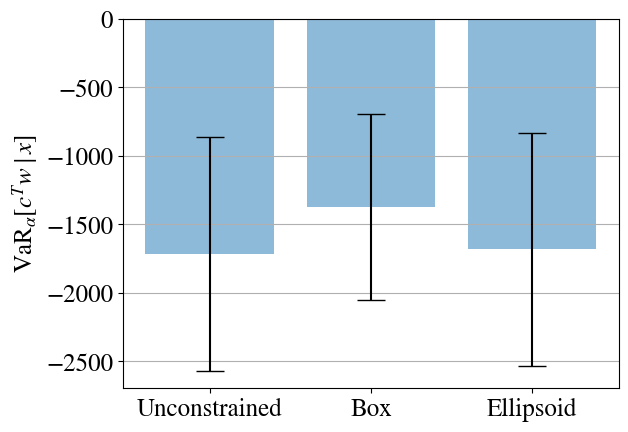

In [107]:
# Create lists for the plot
setups = ['Unconstrained', 'Box', 'Ellipsoid']
x_pos = np.arange(len(setups))
setup_results = [nonrobs, boxes, ellipsoids]

means = [np.mean(setup_result) for setup_result in setup_results]
stds = [np.std(setup_result) for setup_result in setup_results]

fig, ax = plt.subplots()
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel(r"$\mathrm{VaR}_{\alpha}[c^{T} w\mid x]$")
ax.set_xticks(x_pos)
ax.set_xticklabels(setups)
ax.yaxis.grid(True)